## 采用ResNet50神经网络结构训练模型精度超96.6%
Author:zss33266  
Date:2019-07-02


本分享是在第一期猫狗NoteBook实验基础上，把原有的VGG模型结构替换成了ResNet50神经网络结构,主要做的改动是在原有的依赖库上引用了一些新的包，以及训练的参数也进行了一些调整，有些核心的地方我做了注释：

- 像读取数据集部分，原有的图像SIZE过小，在ResNet50神经网络结构中图像的长和宽至少要resize到 197 * 197 大小，即ROWS = 197，COLS = 197
- 打标签的地方，将原有的数字分类，转为成One-Hot向量，labels = np_utils.to_categorical(labels, 2)
- 模型替换为ResNet50的核心代码，ResNet50会从网上下载模型，速度看运气，华为云下载的速度还是比较快的，默认的下载地址是：https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
```
base_model = ResNet50(weights="imagenet", include_top=False, pooling=None, input_shape=(ROWS, COLS, CHANNELS), classes=2)
```
- 我将训练的轮数、批次大小、提前停止策略参数，反复调整，最后结果仅供参考：
```
epochs = 50 # 训练轮数
batch_size = 20 # 批大小
```
```
# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')  
```
- 整个模型需要训练的参数达到上亿，Total params: 126,351,234，训练时间会略长，华为云P100的计算资源还是很给力的，最后迭代12轮左右之后，耗时5~8分钟左右，模型最后的评估结果还是比较高的，其中训练精度达到98.14%,验证集精度达到97.48%

```
loss: 0.2783 - acc: 0.9814 - val_loss: 0.3631 - val_acc: 0.9748
```

以上是我的一针对猫狗训练实验的一些经验分享，具体步骤如下：



### 1、准备猫狗图片数据

In [49]:
from modelarts.session import Session
session = Session()

session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

# 使用tar命令解压资源包
!tar xf ./image_recognition.tar.gz

# 清理压缩包
!rm -f ./image_recognition.tar.gz

INFO:obs:Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


### 2、导入依赖库


In [2]:
import os, cv2, random
import numpy as np
import pandas as pd

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential

from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils import np_utils

from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.applications.resnet50 import ResNet50

from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


### 3、读取数据集
读取数据集，并把图像resize到 197 * 197 大小

In [3]:
DATA_DIR = './data/' # 数据集路径

ROWS = 197
COLS = 197
CHANNELS = 3

image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000



### 4、给图片打标签,并将Labels转化为One-Hot向量

In [4]:
labels = []
for i in image_file_names:
    if 'dog' in i:
        labels.append(0)
    else:
        labels.append(1)
        
# 将标签做热点处理
labels = np_utils.to_categorical(labels, 2)
# 切分数据集
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)
#train_data, validate_data, train_label, validate_label = train_test_split(train_data, train_label, test_size=0.25, random_state=10)

#sns.countplot(labels)
for i in range(10):
    print(labels[i])
    print(image_file_names[i])

[1. 0.]
./data/dog.11073.jpg
[1. 0.]
./data/dog.9188.jpg
[0. 1.]
./data/cat.4058.jpg
[0. 1.]
./data/cat.710.jpg
[0. 1.]
./data/cat.9454.jpg
[0. 1.]
./data/cat.1208.jpg
[0. 1.]
./data/cat.6631.jpg
[1. 0.]
./data/dog.4459.jpg
[1. 0.]
./data/dog.11721.jpg
[0. 1.]
./data/cat.10022.jpg


### 5、切分数据集
#### （train_data，train_label）是训练数据，（test_data，test_label）是测试数据。测试数据占25%。

In [5]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)

#### 查看猫狗的样本图片

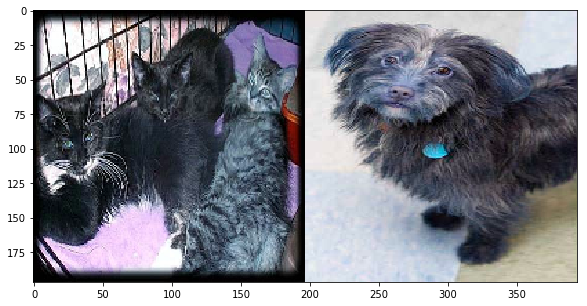

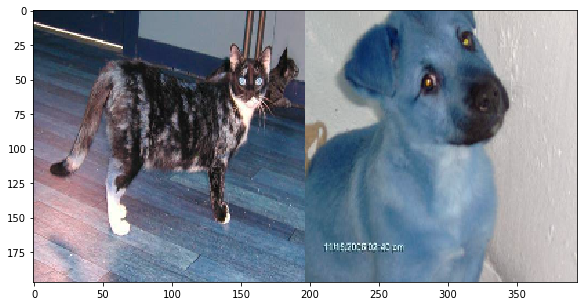

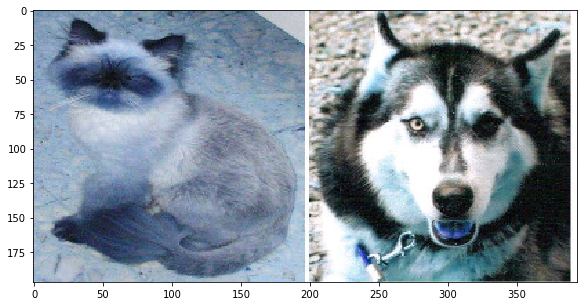

In [6]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

### 6、构建ResNet50网络(下载模型会比较慢，网速好的情况会很快)

In [7]:
#初始化ResNet50基准模型
base_model = ResNet50(weights="imagenet", include_top=False, pooling=None, input_shape=(ROWS, COLS, CHANNELS), classes=2)
# 冻结base_model所有层，这样就可以正确获得bottleneck特征
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
#添加自己的全链接分类层
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)


94658560/94653016 [==============================] - 300s 3us/step


In [8]:
#训练模型
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
# 构建神经网络
optimizer = RMSprop(lr=1e-4) # 优化器使用RMSprop, 设置学习率是1e-4

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])



In [10]:
#训练相关参数
epochs = 50 # 训练轮数
batch_size = 20 # 批大小

# Loss记录
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')   

def run_catdog():
    history = LossHistory()
    
    # 开始训练
    model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.25,  # 训练数据中，抽取25%的数据作为验证数据
        verbose=2,
        shuffle=True,
        callbacks=[history, early_stopping]) 
    
    return  history

In [11]:
#开始训练
history = run_catdog()


Train on 14062 samples, validate on 4688 samples
Epoch 1/50
 - 68s - loss: 8.0039 - acc: 0.5001 - val_loss: 8.2066 - val_acc: 0.4881
Epoch 2/50
 - 60s - loss: 7.8722 - acc: 0.5077 - val_loss: 0.5548 - val_acc: 0.9462
Epoch 3/50
 - 61s - loss: 0.6893 - acc: 0.9429 - val_loss: 0.3478 - val_acc: 0.9738
Epoch 4/50
 - 60s - loss: 0.5350 - acc: 0.9591 - val_loss: 0.5685 - val_acc: 0.9588
Epoch 5/50
 - 61s - loss: 0.4629 - acc: 0.9655 - val_loss: 0.3560 - val_acc: 0.9763
Epoch 6/50
 - 61s - loss: 0.4535 - acc: 0.9666 - val_loss: 0.3261 - val_acc: 0.9776
Epoch 7/50
 - 60s - loss: 0.3893 - acc: 0.9713 - val_loss: 0.4441 - val_acc: 0.9693
Epoch 8/50
 - 60s - loss: 0.3426 - acc: 0.9750 - val_loss: 0.3223 - val_acc: 0.9782
Epoch 9/50
 - 60s - loss: 0.3265 - acc: 0.9767 - val_loss: 0.4318 - val_acc: 0.9708
Epoch 10/50
 - 60s - loss: 0.3566 - acc: 0.9740 - val_loss: 0.4825 - val_acc: 0.9684
Epoch 11/50
 - 61s - loss: 0.3150 - acc: 0.9777 - val_loss: 0.3568 - val_acc: 0.9770
Epoch 12/50
 - 60s - loss

In [47]:
# 训练好的模型可以保存起来，永久使用
OUTPUT = 'output'
if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)
model.save(os.path.join(OUTPUT, 'model.h5'))

### 7.可视化训练过程
将Loss随epoch的变化趋势使用折线图展示

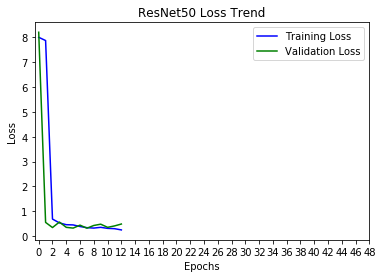

In [12]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

### 8、采用模型预测

[1. 0.]
I am 100.00% sure this is a Dog


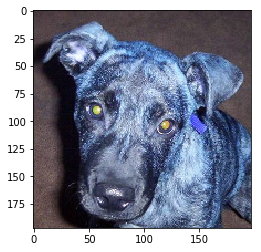

In [13]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)
for i in range(0,1):
    if predictions[i, 0] >= 0.5:         
        print(predictions[i, :])
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print(predictions[i, :])
        print('I am {:.2%} sure this is a Cat'.format(1 - predictions[i][0]))        
    plt.imshow(test_data[i])
    plt.show()

### 9、测试集预测结果

In [15]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)
# 评估模型准确度
predictions_test = []
test_label_test = []
for p in predictions:

    if int(round(p[0])) == 1:
        predictions_test.append(1)
    else:
        predictions_test.append(0)
for t in test_label:
    if int(t[0]) == 1:
        test_label_test.append(1)
    else:
        test_label_test.append(0)
acc = accuracy_score(test_label_test, predictions_test)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.965920
